##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashon MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [12]:
x_train.shape

(60000, 28, 28)

## First example: Basic autoencoder
![Basic autoencoder results](images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [4]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 33s 16ms/step - loss: 0.0238 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 29s 15m

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

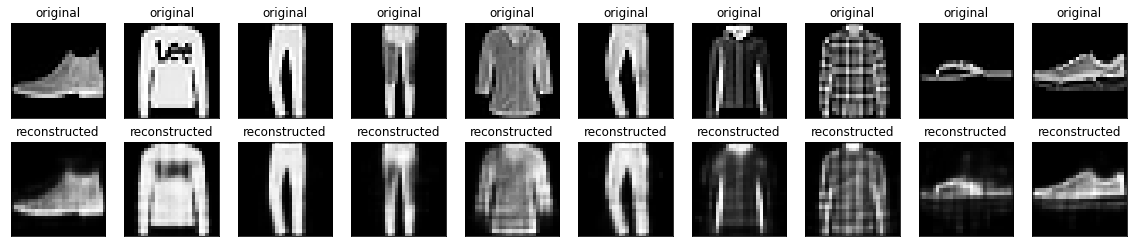

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


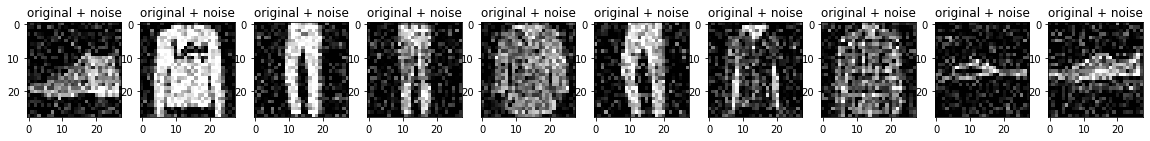

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10



   1/1875 [..............................] - ETA: 44:53 - loss: 0.1689


  22/1875 [..............................] - ETA: 4s - loss: 0.1631   


  44/1875 [..............................] - ETA: 4s - loss: 0.1486


  67/1875 [>.............................] - ETA: 4s - loss: 0.1195


  88/1875 [>.............................] - ETA: 4s - loss: 0.0981


 110/1875 [>.............................] - ETA: 4s - loss: 0.0837


 133/1875 [=>............................] - ETA: 4s - loss: 0.0733


 155/1875 [=>............................] - ETA: 3s - loss: 0.0660


 177/1875 [=>............................] - ETA: 3s - loss: 0.0604


 199/1875 [==>...........................] - ETA: 3s - loss: 0.0558


 222/1875 [==>...........................] - ETA: 3s - loss: 0.0520


 244/1875 [==>...........................] - ETA: 3s - loss: 0.0489


 265/1875 [===>..........................] - ETA: 3s - loss: 0.0464


 287/1875 [===>..........................] - ETA: 3s - loss: 0.0441


 309/1875 [===>..........................] - ETA: 3s - loss: 0.0421


 332/1875 [====>.........................] - ETA: 3s - loss: 0.0402


 355/1875 [====>.........................] - ETA: 3s - loss: 0.0386


 377/1875 [=====>........................] - ETA: 3s - loss: 0.0372


 398/1875 [=====>........................] - ETA: 3s - loss: 0.0360


 420/1875 [=====>........................] - ETA: 3s - loss: 0.0349


 442/1875 [======>.......................] - ETA: 3s - loss: 0.0338


 464/1875 [======>.......................] - ETA: 3s - loss: 0.0329


 486/1875 [======>.......................] - ETA: 3s - loss: 0.0320


 507/1875 [=======>......................] - ETA: 3s - loss: 0.0313


 529/1875 [=======>......................] - ETA: 3s - loss: 0.0305


 551/1875 [=======>......................] - ETA: 3s - loss: 0.0298


 574/1875 [========>.....................] - ETA: 3s - loss: 0.0292


 597/1875 [========>.....................] - ETA: 2s - loss: 0.0285


 620/1875 [========>.....................] - ETA: 2s - loss: 0.0279


 643/1875 [=========>....................] - ETA: 2s - loss: 0.0274


 666/1875 [=========>....................] - ETA: 2s - loss: 0.0269


 689/1875 [==========>...................] - ETA: 2s - loss: 0.0264


 712/1875 [==========>...................] - ETA: 2s - loss: 0.0259


 735/1875 [==========>...................] - ETA: 2s - loss: 0.0255


 758/1875 [===========>..................] - ETA: 2s - loss: 0.0251


 781/1875 [===========>..................] - ETA: 2s - loss: 0.0247


 803/1875 [===========>..................] - ETA: 2s - loss: 0.0244


 826/1875 [============>.................] - ETA: 2s - loss: 0.0240


 849/1875 [============>.................] - ETA: 2s - loss: 0.0237


 871/1875 [============>.................] - ETA: 2s - loss: 0.0234


 894/1875 [=============>................] - ETA: 2s - loss: 0.0231


 916/1875 [=============>................] - ETA: 2s - loss: 0.0228


 939/1875 [==============>...............] - ETA: 2s - loss: 0.0225


 962/1875 [==============>...............] - ETA: 2s - loss: 0.0223


 985/1875 [==============>...............] - ETA: 2s - loss: 0.0220


1008/1875 [===============>..............] - ETA: 1s - loss: 0.0218


1031/1875 [===============>..............] - ETA: 1s - loss: 0.0215


1054/1875 [===============>..............] - ETA: 1s - loss: 0.0213


1077/1875 [================>.............] - ETA: 1s - loss: 0.0211


1100/1875 [================>.............] - ETA: 1s - loss: 0.0209


1123/1875 [================>.............] - ETA: 1s - loss: 0.0207


1146/1875 [=================>............] - ETA: 1s - loss: 0.0205


1168/1875 [=================>............] - ETA: 1s - loss: 0.0203


1191/1875 [==================>...........] - ETA: 1s - loss: 0.0201


1214/1875 [==================>...........] - ETA: 1s - loss: 0.0199


1236/1875 [==================>...........] - ETA: 1s - loss: 0.0198


1257/1875 [===================>..........] - ETA: 1s - loss: 0.0196


1279/1875 [===================>..........] - ETA: 1s - loss: 0.0194


1301/1875 [===================>..........] - ETA: 1s - loss: 0.0193


1323/1875 [====================>.........] - ETA: 1s - loss: 0.0191


1345/1875 [====================>.........] - ETA: 1s - loss: 0.0190


1368/1875 [====================>.........] - ETA: 1s - loss: 0.0189


1391/1875 [=====================>........] - ETA: 1s - loss: 0.0187


1414/1875 [=====================>........] - ETA: 1s - loss: 0.0186


1436/1875 [=====================>........] - ETA: 1s - loss: 0.0185


1459/1875 [======================>.......] - ETA: 0s - loss: 0.0183


1482/1875 [======================>.......] - ETA: 0s - loss: 0.0182


1505/1875 [=======================>......] - ETA: 0s - loss: 0.0181


1527/1875 [=======================>......] - ETA: 0s - loss: 0.0180


1549/1875 [=======================>......] - ETA: 0s - loss: 0.0179


1572/1875 [========================>.....] - ETA: 0s - loss: 0.0177


1595/1875 [========================>.....] - ETA: 0s - loss: 0.0176


1617/1875 [========================>.....] - ETA: 0s - loss: 0.0175


1640/1875 [=========================>....] - ETA: 0s - loss: 0.0174


1663/1875 [=========================>....] - ETA: 0s - loss: 0.0173


1686/1875 [=========================>....] - ETA: 0s - loss: 0.0172


1708/1875 [==========================>...] - ETA: 0s - loss: 0.0171


1730/1875 [==========================>...] - ETA: 0s - loss: 0.0170


1752/1875 [===========================>..] - ETA: 0s - loss: 0.0169


1774/1875 [===========================>..] - ETA: 0s - loss: 0.0169


1797/1875 [===========================>..] - ETA: 0s - loss: 0.0168


1819/1875 [============================>.] - ETA: 0s - loss: 0.0167


1840/1875 [============================>.] - ETA: 0s - loss: 0.0166


1861/1875 [============================>.] - ETA: 0s - loss: 0.0165


1875/1875 [==============================] - 6s 3ms/step - loss: 0.0165 - val_loss: 0.0100


Epoch 2/10

   1/1875 [..............................] - ETA: 5s - loss: 0.0098


  23/1875 [..............................] - ETA: 4s - loss: 0.0098


  46/1875 [..............................] - ETA: 4s - loss: 0.0098


  68/1875 [>.............................] - ETA: 4s - loss: 0.0099


  89/1875 [>.............................] - ETA: 4s - loss: 0.0099


 111/1875 [>.............................] - ETA: 4s - loss: 0.0099


 134/1875 [=>............................] - ETA: 3s - loss: 0.0098


 156/1875 [=>............................] - ETA: 3s - loss: 0.0098


 178/1875 [=>............................] - ETA: 3s - loss: 0.0098


 200/1875 [==>...........................] - ETA: 3s - loss: 0.0098


 223/1875 [==>...........................] - ETA: 3s - loss: 0.0098


 246/1875 [==>...........................] - ETA: 3s - loss: 0.0098


 269/1875 [===>..........................] - ETA: 3s - loss: 0.0098


 292/1875 [===>..........................] - ETA: 3s - loss: 0.0098


 315/1875 [====>.........................] - ETA: 3s - loss: 0.0098


 337/1875 [====>.........................] - ETA: 3s - loss: 0.0098


 359/1875 [====>.........................] - ETA: 3s - loss: 0.0098


 381/1875 [=====>........................] - ETA: 3s - loss: 0.0098


 404/1875 [=====>........................] - ETA: 3s - loss: 0.0098


 426/1875 [=====>........................] - ETA: 3s - loss: 0.0098


 448/1875 [======>.......................] - ETA: 3s - loss: 0.0098


 469/1875 [======>.......................] - ETA: 3s - loss: 0.0098


 491/1875 [======>.......................] - ETA: 3s - loss: 0.0098


 513/1875 [=======>......................] - ETA: 3s - loss: 0.0098


 536/1875 [=======>......................] - ETA: 3s - loss: 0.0098


 558/1875 [=======>......................] - ETA: 3s - loss: 0.0097


 581/1875 [========>.....................] - ETA: 2s - loss: 0.0097


 604/1875 [========>.....................] - ETA: 2s - loss: 0.0097


 627/1875 [=========>....................] - ETA: 2s - loss: 0.0097


 650/1875 [=========>....................] - ETA: 2s - loss: 0.0097


 673/1875 [=========>....................] - ETA: 2s - loss: 0.0097


 694/1875 [==========>...................] - ETA: 2s - loss: 0.0097


 715/1875 [==========>...................] - ETA: 2s - loss: 0.0097


 736/1875 [==========>...................] - ETA: 2s - loss: 0.0097


 758/1875 [===========>..................] - ETA: 2s - loss: 0.0097


 780/1875 [===========>..................] - ETA: 2s - loss: 0.0097


 803/1875 [===========>..................] - ETA: 2s - loss: 0.0097


 826/1875 [============>.................] - ETA: 2s - loss: 0.0097


 849/1875 [============>.................] - ETA: 2s - loss: 0.0097


 872/1875 [============>.................] - ETA: 2s - loss: 0.0097


 895/1875 [=============>................] - ETA: 2s - loss: 0.0097


 918/1875 [=============>................] - ETA: 2s - loss: 0.0097


 941/1875 [==============>...............] - ETA: 2s - loss: 0.0097


 964/1875 [==============>...............] - ETA: 2s - loss: 0.0096


 986/1875 [==============>...............] - ETA: 2s - loss: 0.0096


1009/1875 [===============>..............] - ETA: 1s - loss: 0.0096


1032/1875 [===============>..............] - ETA: 1s - loss: 0.0096


1055/1875 [===============>..............] - ETA: 1s - loss: 0.0096


1077/1875 [================>.............] - ETA: 1s - loss: 0.0096


1100/1875 [================>.............] - ETA: 1s - loss: 0.0096


1123/1875 [================>.............] - ETA: 1s - loss: 0.0096


1146/1875 [=================>............] - ETA: 1s - loss: 0.0096


1169/1875 [=================>............] - ETA: 1s - loss: 0.0096


1192/1875 [==================>...........] - ETA: 1s - loss: 0.0096


1214/1875 [==================>...........] - ETA: 1s - loss: 0.0096


1237/1875 [==================>...........] - ETA: 1s - loss: 0.0096


1259/1875 [===================>..........] - ETA: 1s - loss: 0.0096


1282/1875 [===================>..........] - ETA: 1s - loss: 0.0096


1304/1875 [===================>..........] - ETA: 1s - loss: 0.0096


1326/1875 [====================>.........] - ETA: 1s - loss: 0.0096


1349/1875 [====================>.........] - ETA: 1s - loss: 0.0096


1371/1875 [====================>.........] - ETA: 1s - loss: 0.0096


1393/1875 [=====================>........] - ETA: 1s - loss: 0.0096


1416/1875 [=====================>........] - ETA: 1s - loss: 0.0095


1439/1875 [======================>.......] - ETA: 0s - loss: 0.0095


1461/1875 [======================>.......] - ETA: 0s - loss: 0.0095


1484/1875 [======================>.......] - ETA: 0s - loss: 0.0095


1507/1875 [=======================>......] - ETA: 0s - loss: 0.0095


1530/1875 [=======================>......] - ETA: 0s - loss: 0.0095


1553/1875 [=======================>......] - ETA: 0s - loss: 0.0095


1575/1875 [========================>.....] - ETA: 0s - loss: 0.0095


1598/1875 [========================>.....] - ETA: 0s - loss: 0.0095


1621/1875 [========================>.....] - ETA: 0s - loss: 0.0095


1644/1875 [=========================>....] - ETA: 0s - loss: 0.0095


1666/1875 [=========================>....] - ETA: 0s - loss: 0.0095


1688/1875 [==========================>...] - ETA: 0s - loss: 0.0095


1710/1875 [==========================>...] - ETA: 0s - loss: 0.0095


1732/1875 [==========================>...] - ETA: 0s - loss: 0.0095


1755/1875 [===========================>..] - ETA: 0s - loss: 0.0095


1776/1875 [===========================>..] - ETA: 0s - loss: 0.0094


1798/1875 [===========================>..] - ETA: 0s - loss: 0.0094


1821/1875 [============================>.] - ETA: 0s - loss: 0.0094


1844/1875 [============================>.] - ETA: 0s - loss: 0.0094


1866/1875 [============================>.] - ETA: 0s - loss: 0.0094


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0094 - val_loss: 0.0089


Epoch 3/10

   1/1875 [..............................] - ETA: 4s - loss: 0.0082


  22/1875 [..............................] - ETA: 4s - loss: 0.0088


  44/1875 [..............................] - ETA: 4s - loss: 0.0088


  67/1875 [>.............................] - ETA: 4s - loss: 0.0087


  89/1875 [>.............................] - ETA: 4s - loss: 0.0087


 111/1875 [>.............................] - ETA: 4s - loss: 0.0087


 134/1875 [=>............................] - ETA: 3s - loss: 0.0087


 157/1875 [=>............................] - ETA: 3s - loss: 0.0087


 180/1875 [=>............................] - ETA: 3s - loss: 0.0087


 203/1875 [==>...........................] - ETA: 3s - loss: 0.0087


 226/1875 [==>...........................] - ETA: 3s - loss: 0.0087


 249/1875 [==>...........................] - ETA: 3s - loss: 0.0087


 272/1875 [===>..........................] - ETA: 3s - loss: 0.0087


 295/1875 [===>..........................] - ETA: 3s - loss: 0.0087


 318/1875 [====>.........................] - ETA: 3s - loss: 0.0087


 341/1875 [====>.........................] - ETA: 3s - loss: 0.0087


 364/1875 [====>.........................] - ETA: 3s - loss: 0.0087


 386/1875 [=====>........................] - ETA: 3s - loss: 0.0087


 408/1875 [=====>........................] - ETA: 3s - loss: 0.0087


 431/1875 [=====>........................] - ETA: 3s - loss: 0.0087


 453/1875 [======>.......................] - ETA: 3s - loss: 0.0087


 474/1875 [======>.......................] - ETA: 3s - loss: 0.0087


 495/1875 [======>.......................] - ETA: 3s - loss: 0.0087


 516/1875 [=======>......................] - ETA: 3s - loss: 0.0087


 537/1875 [=======>......................] - ETA: 3s - loss: 0.0087


 558/1875 [=======>......................] - ETA: 3s - loss: 0.0087


 581/1875 [========>.....................] - ETA: 2s - loss: 0.0087


 603/1875 [========>.....................] - ETA: 2s - loss: 0.0086


 626/1875 [=========>....................] - ETA: 2s - loss: 0.0086


 649/1875 [=========>....................] - ETA: 2s - loss: 0.0086


 672/1875 [=========>....................] - ETA: 2s - loss: 0.0086


 694/1875 [==========>...................] - ETA: 2s - loss: 0.0086


 717/1875 [==========>...................] - ETA: 2s - loss: 0.0086


 740/1875 [==========>...................] - ETA: 2s - loss: 0.0086


 763/1875 [===========>..................] - ETA: 2s - loss: 0.0086


 786/1875 [===========>..................] - ETA: 2s - loss: 0.0086


 809/1875 [===========>..................] - ETA: 2s - loss: 0.0086


 832/1875 [============>.................] - ETA: 2s - loss: 0.0086


 854/1875 [============>.................] - ETA: 2s - loss: 0.0086


 877/1875 [=============>................] - ETA: 2s - loss: 0.0086


 900/1875 [=============>................] - ETA: 2s - loss: 0.0086


 922/1875 [=============>................] - ETA: 2s - loss: 0.0086


 945/1875 [==============>...............] - ETA: 2s - loss: 0.0086


 967/1875 [==============>...............] - ETA: 2s - loss: 0.0085


 989/1875 [==============>...............] - ETA: 2s - loss: 0.0085


1011/1875 [===============>..............] - ETA: 1s - loss: 0.0085


1033/1875 [===============>..............] - ETA: 1s - loss: 0.0085


1054/1875 [===============>..............] - ETA: 1s - loss: 0.0085


1076/1875 [================>.............] - ETA: 1s - loss: 0.0085


1099/1875 [================>.............] - ETA: 1s - loss: 0.0085


1122/1875 [================>.............] - ETA: 1s - loss: 0.0085


1145/1875 [=================>............] - ETA: 1s - loss: 0.0085


1168/1875 [=================>............] - ETA: 1s - loss: 0.0085


1191/1875 [==================>...........] - ETA: 1s - loss: 0.0085


1214/1875 [==================>...........] - ETA: 1s - loss: 0.0085


1237/1875 [==================>...........] - ETA: 1s - loss: 0.0085


1260/1875 [===================>..........] - ETA: 1s - loss: 0.0085


1283/1875 [===================>..........] - ETA: 1s - loss: 0.0085


1306/1875 [===================>..........] - ETA: 1s - loss: 0.0085


1329/1875 [====================>.........] - ETA: 1s - loss: 0.0085


1352/1875 [====================>.........] - ETA: 1s - loss: 0.0084


1375/1875 [=====================>........] - ETA: 1s - loss: 0.0084


1397/1875 [=====================>........] - ETA: 1s - loss: 0.0084


1419/1875 [=====================>........] - ETA: 1s - loss: 0.0084


1440/1875 [======================>.......] - ETA: 0s - loss: 0.0084


1462/1875 [======================>.......] - ETA: 0s - loss: 0.0084


1485/1875 [======================>.......] - ETA: 0s - loss: 0.0084


1508/1875 [=======================>......] - ETA: 0s - loss: 0.0084


1531/1875 [=======================>......] - ETA: 0s - loss: 0.0084


1554/1875 [=======================>......] - ETA: 0s - loss: 0.0084


1576/1875 [========================>.....] - ETA: 0s - loss: 0.0084


1598/1875 [========================>.....] - ETA: 0s - loss: 0.0084


1621/1875 [========================>.....] - ETA: 0s - loss: 0.0084


1643/1875 [=========================>....] - ETA: 0s - loss: 0.0084


1666/1875 [=========================>....] - ETA: 0s - loss: 0.0084


1689/1875 [==========================>...] - ETA: 0s - loss: 0.0084


1711/1875 [==========================>...] - ETA: 0s - loss: 0.0084


1734/1875 [==========================>...] - ETA: 0s - loss: 0.0084


1756/1875 [===========================>..] - ETA: 0s - loss: 0.0084


1778/1875 [===========================>..] - ETA: 0s - loss: 0.0084


1800/1875 [===========================>..] - ETA: 0s - loss: 0.0084


1822/1875 [============================>.] - ETA: 0s - loss: 0.0084


1845/1875 [============================>.] - ETA: 0s - loss: 0.0083


1867/1875 [============================>.] - ETA: 0s - loss: 0.0083


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0083 - val_loss: 0.0081


Epoch 4/10

   1/1875 [..............................] - ETA: 5s - loss: 0.0078


  23/1875 [..............................] - ETA: 4s - loss: 0.0077


  45/1875 [..............................] - ETA: 4s - loss: 0.0078


  66/1875 [>.............................] - ETA: 4s - loss: 0.0079


  87/1875 [>.............................] - ETA: 4s - loss: 0.0079


 109/1875 [>.............................] - ETA: 4s - loss: 0.0079


 132/1875 [=>............................] - ETA: 4s - loss: 0.0079


 155/1875 [=>............................] - ETA: 3s - loss: 0.0079


 177/1875 [=>............................] - ETA: 3s - loss: 0.0079


 199/1875 [==>...........................] - ETA: 3s - loss: 0.0079


 221/1875 [==>...........................] - ETA: 3s - loss: 0.0079


 244/1875 [==>...........................] - ETA: 3s - loss: 0.0079


 266/1875 [===>..........................] - ETA: 3s - loss: 0.0079


 289/1875 [===>..........................] - ETA: 3s - loss: 0.0079


 312/1875 [===>..........................] - ETA: 3s - loss: 0.0080


 335/1875 [====>.........................] - ETA: 3s - loss: 0.0080


 358/1875 [====>.........................] - ETA: 3s - loss: 0.0079


 381/1875 [=====>........................] - ETA: 3s - loss: 0.0079


 404/1875 [=====>........................] - ETA: 3s - loss: 0.0079


 427/1875 [=====>........................] - ETA: 3s - loss: 0.0079


 450/1875 [======>.......................] - ETA: 3s - loss: 0.0079


 472/1875 [======>.......................] - ETA: 3s - loss: 0.0079


 494/1875 [======>.......................] - ETA: 3s - loss: 0.0079


 517/1875 [=======>......................] - ETA: 3s - loss: 0.0079


 540/1875 [=======>......................] - ETA: 3s - loss: 0.0079


 562/1875 [=======>......................] - ETA: 3s - loss: 0.0079


 583/1875 [========>.....................] - ETA: 2s - loss: 0.0079


 606/1875 [========>.....................] - ETA: 2s - loss: 0.0079


 629/1875 [=========>....................] - ETA: 2s - loss: 0.0079


 652/1875 [=========>....................] - ETA: 2s - loss: 0.0079


 674/1875 [=========>....................] - ETA: 2s - loss: 0.0079


 696/1875 [==========>...................] - ETA: 2s - loss: 0.0079


 718/1875 [==========>...................] - ETA: 2s - loss: 0.0079


 740/1875 [==========>...................] - ETA: 2s - loss: 0.0079


 763/1875 [===========>..................] - ETA: 2s - loss: 0.0079


 785/1875 [===========>..................] - ETA: 2s - loss: 0.0079


 807/1875 [===========>..................] - ETA: 2s - loss: 0.0079


 829/1875 [============>.................] - ETA: 2s - loss: 0.0079


 851/1875 [============>.................] - ETA: 2s - loss: 0.0079


 873/1875 [============>.................] - ETA: 2s - loss: 0.0079


 896/1875 [=============>................] - ETA: 2s - loss: 0.0079


 919/1875 [=============>................] - ETA: 2s - loss: 0.0079


 942/1875 [==============>...............] - ETA: 2s - loss: 0.0079


 965/1875 [==============>...............] - ETA: 2s - loss: 0.0079


 988/1875 [==============>...............] - ETA: 2s - loss: 0.0079


1011/1875 [===============>..............] - ETA: 1s - loss: 0.0079


1033/1875 [===============>..............] - ETA: 1s - loss: 0.0079


1056/1875 [===============>..............] - ETA: 1s - loss: 0.0079


1079/1875 [================>.............] - ETA: 1s - loss: 0.0079


1101/1875 [================>.............] - ETA: 1s - loss: 0.0079


1123/1875 [================>.............] - ETA: 1s - loss: 0.0079


1145/1875 [=================>............] - ETA: 1s - loss: 0.0079


1168/1875 [=================>............] - ETA: 1s - loss: 0.0079


1191/1875 [==================>...........] - ETA: 1s - loss: 0.0079


1214/1875 [==================>...........] - ETA: 1s - loss: 0.0079


1236/1875 [==================>...........] - ETA: 1s - loss: 0.0079


1259/1875 [===================>..........] - ETA: 1s - loss: 0.0079


1282/1875 [===================>..........] - ETA: 1s - loss: 0.0079


1305/1875 [===================>..........] - ETA: 1s - loss: 0.0079


1328/1875 [====================>.........] - ETA: 1s - loss: 0.0079


1351/1875 [====================>.........] - ETA: 1s - loss: 0.0079


1374/1875 [====================>.........] - ETA: 1s - loss: 0.0079


1397/1875 [=====================>........] - ETA: 1s - loss: 0.0079


1419/1875 [=====================>........] - ETA: 1s - loss: 0.0078


1442/1875 [======================>.......] - ETA: 0s - loss: 0.0078


1465/1875 [======================>.......] - ETA: 0s - loss: 0.0078


1488/1875 [======================>.......] - ETA: 0s - loss: 0.0078


1511/1875 [=======================>......] - ETA: 0s - loss: 0.0078


1534/1875 [=======================>......] - ETA: 0s - loss: 0.0078


1556/1875 [=======================>......] - ETA: 0s - loss: 0.0078


1578/1875 [========================>.....] - ETA: 0s - loss: 0.0078


1599/1875 [========================>.....] - ETA: 0s - loss: 0.0078


1621/1875 [========================>.....] - ETA: 0s - loss: 0.0078


1644/1875 [=========================>....] - ETA: 0s - loss: 0.0078


1667/1875 [=========================>....] - ETA: 0s - loss: 0.0078


1690/1875 [==========================>...] - ETA: 0s - loss: 0.0078


1712/1875 [==========================>...] - ETA: 0s - loss: 0.0078


1734/1875 [==========================>...] - ETA: 0s - loss: 0.0078


1756/1875 [===========================>..] - ETA: 0s - loss: 0.0078


1778/1875 [===========================>..] - ETA: 0s - loss: 0.0078


1801/1875 [===========================>..] - ETA: 0s - loss: 0.0078


1823/1875 [============================>.] - ETA: 0s - loss: 0.0078


1846/1875 [============================>.] - ETA: 0s - loss: 0.0078


1869/1875 [============================>.] - ETA: 0s - loss: 0.0078


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0078 - val_loss: 0.0077


Epoch 5/10

   1/1875 [..............................] - ETA: 5s - loss: 0.0079


  24/1875 [..............................] - ETA: 4s - loss: 0.0075


  46/1875 [..............................] - ETA: 4s - loss: 0.0075


  68/1875 [>.............................] - ETA: 4s - loss: 0.0075


  88/1875 [>.............................] - ETA: 4s - loss: 0.0075


 108/1875 [>.............................] - ETA: 4s - loss: 0.0076


 128/1875 [=>............................] - ETA: 4s - loss: 0.0076


 148/1875 [=>............................] - ETA: 4s - loss: 0.0076


 169/1875 [=>............................] - ETA: 4s - loss: 0.0076


 190/1875 [==>...........................] - ETA: 4s - loss: 0.0076


 211/1875 [==>...........................] - ETA: 4s - loss: 0.0076


 232/1875 [==>...........................] - ETA: 3s - loss: 0.0076


 253/1875 [===>..........................] - ETA: 3s - loss: 0.0077


 274/1875 [===>..........................] - ETA: 3s - loss: 0.0077


 296/1875 [===>..........................] - ETA: 3s - loss: 0.0076


 318/1875 [====>.........................] - ETA: 3s - loss: 0.0076


 341/1875 [====>.........................] - ETA: 3s - loss: 0.0076


 363/1875 [====>.........................] - ETA: 3s - loss: 0.0076


 385/1875 [=====>........................] - ETA: 3s - loss: 0.0076


 407/1875 [=====>........................] - ETA: 3s - loss: 0.0077


 429/1875 [=====>........................] - ETA: 3s - loss: 0.0077


 452/1875 [======>.......................] - ETA: 3s - loss: 0.0076


 474/1875 [======>.......................] - ETA: 3s - loss: 0.0077


 497/1875 [======>.......................] - ETA: 3s - loss: 0.0077


 520/1875 [=======>......................] - ETA: 3s - loss: 0.0077


 543/1875 [=======>......................] - ETA: 3s - loss: 0.0076


 566/1875 [========>.....................] - ETA: 3s - loss: 0.0076


 588/1875 [========>.....................] - ETA: 3s - loss: 0.0076


 609/1875 [========>.....................] - ETA: 2s - loss: 0.0076


 632/1875 [=========>....................] - ETA: 2s - loss: 0.0076


 655/1875 [=========>....................] - ETA: 2s - loss: 0.0076


 678/1875 [=========>....................] - ETA: 2s - loss: 0.0076


 700/1875 [==========>...................] - ETA: 2s - loss: 0.0076


 721/1875 [==========>...................] - ETA: 2s - loss: 0.0076


 743/1875 [==========>...................] - ETA: 2s - loss: 0.0076


 766/1875 [===========>..................] - ETA: 2s - loss: 0.0076


 787/1875 [===========>..................] - ETA: 2s - loss: 0.0076


 809/1875 [===========>..................] - ETA: 2s - loss: 0.0076


 832/1875 [============>.................] - ETA: 2s - loss: 0.0076


 855/1875 [============>.................] - ETA: 2s - loss: 0.0076


 878/1875 [=============>................] - ETA: 2s - loss: 0.0076


 900/1875 [=============>................] - ETA: 2s - loss: 0.0076


 923/1875 [=============>................] - ETA: 2s - loss: 0.0076


 946/1875 [==============>...............] - ETA: 2s - loss: 0.0076


 968/1875 [==============>...............] - ETA: 2s - loss: 0.0076


 991/1875 [==============>...............] - ETA: 2s - loss: 0.0076


1014/1875 [===============>..............] - ETA: 2s - loss: 0.0076


1037/1875 [===============>..............] - ETA: 1s - loss: 0.0076


1059/1875 [===============>..............] - ETA: 1s - loss: 0.0076


1082/1875 [================>.............] - ETA: 1s - loss: 0.0076


1104/1875 [================>.............] - ETA: 1s - loss: 0.0076


1127/1875 [=================>............] - ETA: 1s - loss: 0.0076


1150/1875 [=================>............] - ETA: 1s - loss: 0.0076


1173/1875 [=================>............] - ETA: 1s - loss: 0.0076


1196/1875 [==================>...........] - ETA: 1s - loss: 0.0076


1219/1875 [==================>...........] - ETA: 1s - loss: 0.0076


1241/1875 [==================>...........] - ETA: 1s - loss: 0.0076


1264/1875 [===================>..........] - ETA: 1s - loss: 0.0076


1286/1875 [===================>..........] - ETA: 1s - loss: 0.0076


1309/1875 [===================>..........] - ETA: 1s - loss: 0.0076


1331/1875 [====================>.........] - ETA: 1s - loss: 0.0076


1352/1875 [====================>.........] - ETA: 1s - loss: 0.0076


1373/1875 [====================>.........] - ETA: 1s - loss: 0.0076


1395/1875 [=====================>........] - ETA: 1s - loss: 0.0076


1416/1875 [=====================>........] - ETA: 1s - loss: 0.0076


1438/1875 [======================>.......] - ETA: 1s - loss: 0.0076


1461/1875 [======================>.......] - ETA: 0s - loss: 0.0076


1484/1875 [======================>.......] - ETA: 0s - loss: 0.0076


1507/1875 [=======================>......] - ETA: 0s - loss: 0.0076


1530/1875 [=======================>......] - ETA: 0s - loss: 0.0076


1553/1875 [=======================>......] - ETA: 0s - loss: 0.0076


1575/1875 [========================>.....] - ETA: 0s - loss: 0.0076


1598/1875 [========================>.....] - ETA: 0s - loss: 0.0076


1619/1875 [========================>.....] - ETA: 0s - loss: 0.0075


1640/1875 [=========================>....] - ETA: 0s - loss: 0.0075


1662/1875 [=========================>....] - ETA: 0s - loss: 0.0075


1685/1875 [=========================>....] - ETA: 0s - loss: 0.0075


1708/1875 [==========================>...] - ETA: 0s - loss: 0.0075


1731/1875 [==========================>...] - ETA: 0s - loss: 0.0075


1754/1875 [===========================>..] - ETA: 0s - loss: 0.0075


1777/1875 [===========================>..] - ETA: 0s - loss: 0.0075


1800/1875 [===========================>..] - ETA: 0s - loss: 0.0075


1823/1875 [============================>.] - ETA: 0s - loss: 0.0076


1846/1875 [============================>.] - ETA: 0s - loss: 0.0076


1868/1875 [============================>.] - ETA: 0s - loss: 0.0076


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0076 - val_loss: 0.0075


Epoch 6/10

   1/1875 [..............................] - ETA: 4s - loss: 0.0070


  24/1875 [..............................] - ETA: 4s - loss: 0.0075


  46/1875 [..............................] - ETA: 4s - loss: 0.0075


  68/1875 [>.............................] - ETA: 4s - loss: 0.0075


  91/1875 [>.............................] - ETA: 4s - loss: 0.0074


 114/1875 [>.............................] - ETA: 3s - loss: 0.0075


 136/1875 [=>............................] - ETA: 3s - loss: 0.0075


 159/1875 [=>............................] - ETA: 3s - loss: 0.0074


 182/1875 [=>............................] - ETA: 3s - loss: 0.0075


 205/1875 [==>...........................] - ETA: 3s - loss: 0.0074


 228/1875 [==>...........................] - ETA: 3s - loss: 0.0074


 251/1875 [===>..........................] - ETA: 3s - loss: 0.0074


 274/1875 [===>..........................] - ETA: 3s - loss: 0.0074


 297/1875 [===>..........................] - ETA: 3s - loss: 0.0074


 320/1875 [====>.........................] - ETA: 3s - loss: 0.0075


 343/1875 [====>.........................] - ETA: 3s - loss: 0.0074


 366/1875 [====>.........................] - ETA: 3s - loss: 0.0074


 388/1875 [=====>........................] - ETA: 3s - loss: 0.0074


 410/1875 [=====>........................] - ETA: 3s - loss: 0.0074


 431/1875 [=====>........................] - ETA: 3s - loss: 0.0075


 452/1875 [======>.......................] - ETA: 3s - loss: 0.0075


 475/1875 [======>.......................] - ETA: 3s - loss: 0.0075


 498/1875 [======>.......................] - ETA: 3s - loss: 0.0075


 521/1875 [=======>......................] - ETA: 3s - loss: 0.0075


 544/1875 [=======>......................] - ETA: 3s - loss: 0.0075


 567/1875 [========>.....................] - ETA: 2s - loss: 0.0075


 590/1875 [========>.....................] - ETA: 2s - loss: 0.0074


 613/1875 [========>.....................] - ETA: 2s - loss: 0.0075


 636/1875 [=========>....................] - ETA: 2s - loss: 0.0075


 659/1875 [=========>....................] - ETA: 2s - loss: 0.0074


 682/1875 [=========>....................] - ETA: 2s - loss: 0.0074


 705/1875 [==========>...................] - ETA: 2s - loss: 0.0074


 728/1875 [==========>...................] - ETA: 2s - loss: 0.0074


 751/1875 [===========>..................] - ETA: 2s - loss: 0.0074


 774/1875 [===========>..................] - ETA: 2s - loss: 0.0074


 797/1875 [===========>..................] - ETA: 2s - loss: 0.0074


 820/1875 [============>.................] - ETA: 2s - loss: 0.0074


 842/1875 [============>.................] - ETA: 2s - loss: 0.0074


 865/1875 [============>.................] - ETA: 2s - loss: 0.0074


 887/1875 [=============>................] - ETA: 2s - loss: 0.0074


 909/1875 [=============>................] - ETA: 2s - loss: 0.0074


 931/1875 [=============>................] - ETA: 2s - loss: 0.0074


 953/1875 [==============>...............] - ETA: 2s - loss: 0.0074


 975/1875 [==============>...............] - ETA: 2s - loss: 0.0074


 997/1875 [==============>...............] - ETA: 1s - loss: 0.0074


1019/1875 [===============>..............] - ETA: 1s - loss: 0.0074


1041/1875 [===============>..............] - ETA: 1s - loss: 0.0074


1064/1875 [================>.............] - ETA: 1s - loss: 0.0074


1087/1875 [================>.............] - ETA: 1s - loss: 0.0074


1110/1875 [================>.............] - ETA: 1s - loss: 0.0074


1133/1875 [=================>............] - ETA: 1s - loss: 0.0074


1156/1875 [=================>............] - ETA: 1s - loss: 0.0074


1179/1875 [=================>............] - ETA: 1s - loss: 0.0074


1202/1875 [==================>...........] - ETA: 1s - loss: 0.0074


1225/1875 [==================>...........] - ETA: 1s - loss: 0.0074


1248/1875 [==================>...........] - ETA: 1s - loss: 0.0074


1270/1875 [===================>..........] - ETA: 1s - loss: 0.0074


1292/1875 [===================>..........] - ETA: 1s - loss: 0.0074


1315/1875 [====================>.........] - ETA: 1s - loss: 0.0074


1337/1875 [====================>.........] - ETA: 1s - loss: 0.0074


1358/1875 [====================>.........] - ETA: 1s - loss: 0.0074


1381/1875 [=====================>........] - ETA: 1s - loss: 0.0074


1401/1875 [=====================>........] - ETA: 1s - loss: 0.0074


1423/1875 [=====================>........] - ETA: 1s - loss: 0.0074


1445/1875 [======================>.......] - ETA: 0s - loss: 0.0074


1467/1875 [======================>.......] - ETA: 0s - loss: 0.0074


1488/1875 [======================>.......] - ETA: 0s - loss: 0.0074


1511/1875 [=======================>......] - ETA: 0s - loss: 0.0074


1534/1875 [=======================>......] - ETA: 0s - loss: 0.0074


1557/1875 [=======================>......] - ETA: 0s - loss: 0.0074


1580/1875 [========================>.....] - ETA: 0s - loss: 0.0074


1603/1875 [========================>.....] - ETA: 0s - loss: 0.0074


1626/1875 [=========================>....] - ETA: 0s - loss: 0.0074


1649/1875 [=========================>....] - ETA: 0s - loss: 0.0074


1672/1875 [=========================>....] - ETA: 0s - loss: 0.0074


1695/1875 [==========================>...] - ETA: 0s - loss: 0.0074


1717/1875 [==========================>...] - ETA: 0s - loss: 0.0074


1738/1875 [==========================>...] - ETA: 0s - loss: 0.0074


1760/1875 [===========================>..] - ETA: 0s - loss: 0.0074


1783/1875 [===========================>..] - ETA: 0s - loss: 0.0074


1806/1875 [===========================>..] - ETA: 0s - loss: 0.0074


1828/1875 [============================>.] - ETA: 0s - loss: 0.0074


1850/1875 [============================>.] - ETA: 0s - loss: 0.0074


1873/1875 [============================>.] - ETA: 0s - loss: 0.0074


1875/1875 [==============================] - 5s 2ms/step - loss: 0.0074 - val_loss: 0.0074


Epoch 7/10

   1/1875 [..............................] - ETA: 4s - loss: 0.0083


  24/1875 [..............................] - ETA: 4s - loss: 0.0072


  47/1875 [..............................] - ETA: 4s - loss: 0.0073


  70/1875 [>.............................] - ETA: 4s - loss: 0.0072


  93/1875 [>.............................] - ETA: 3s - loss: 0.0072


 115/1875 [>.............................] - ETA: 3s - loss: 0.0073


 136/1875 [=>............................] - ETA: 3s - loss: 0.0072


 159/1875 [=>............................] - ETA: 3s - loss: 0.0073


 182/1875 [=>............................] - ETA: 3s - loss: 0.0073


 205/1875 [==>...........................] - ETA: 3s - loss: 0.0073


 228/1875 [==>...........................] - ETA: 3s - loss: 0.0073


 250/1875 [===>..........................] - ETA: 3s - loss: 0.0073


 273/1875 [===>..........................] - ETA: 3s - loss: 0.0073


 296/1875 [===>..........................] - ETA: 3s - loss: 0.0073


 319/1875 [====>.........................] - ETA: 3s - loss: 0.0073


 342/1875 [====>.........................] - ETA: 3s - loss: 0.0073


 365/1875 [====>.........................] - ETA: 3s - loss: 0.0073


 388/1875 [=====>........................] - ETA: 3s - loss: 0.0073


 411/1875 [=====>........................] - ETA: 3s - loss: 0.0073


 434/1875 [=====>........................] - ETA: 3s - loss: 0.0073


 457/1875 [======>.......................] - ETA: 3s - loss: 0.0073


 480/1875 [======>.......................] - ETA: 3s - loss: 0.0073


 503/1875 [=======>......................] - ETA: 3s - loss: 0.0073


 526/1875 [=======>......................] - ETA: 3s - loss: 0.0073


 549/1875 [=======>......................] - ETA: 2s - loss: 0.0073


 572/1875 [========>.....................] - ETA: 2s - loss: 0.0073


 595/1875 [========>.....................] - ETA: 2s - loss: 0.0073


 618/1875 [========>.....................] - ETA: 2s - loss: 0.0073


 639/1875 [=========>....................] - ETA: 2s - loss: 0.0073


 662/1875 [=========>....................] - ETA: 2s - loss: 0.0073


 684/1875 [=========>....................] - ETA: 2s - loss: 0.0073


 706/1875 [==========>...................] - ETA: 2s - loss: 0.0073


 729/1875 [==========>...................] - ETA: 2s - loss: 0.0073


 752/1875 [===========>..................] - ETA: 2s - loss: 0.0073


 775/1875 [===========>..................] - ETA: 2s - loss: 0.0073


 798/1875 [===========>..................] - ETA: 2s - loss: 0.0073


 821/1875 [============>.................] - ETA: 2s - loss: 0.0073


 843/1875 [============>.................] - ETA: 2s - loss: 0.0073


 865/1875 [============>.................] - ETA: 2s - loss: 0.0073


 888/1875 [=============>................] - ETA: 2s - loss: 0.0073


 911/1875 [=============>................] - ETA: 2s - loss: 0.0073


 934/1875 [=============>................] - ETA: 2s - loss: 0.0073


 957/1875 [==============>...............] - ETA: 2s - loss: 0.0073


 980/1875 [==============>...............] - ETA: 2s - loss: 0.0073


1002/1875 [===============>..............] - ETA: 1s - loss: 0.0073


1025/1875 [===============>..............] - ETA: 1s - loss: 0.0073


1047/1875 [===============>..............] - ETA: 1s - loss: 0.0073


1070/1875 [================>.............] - ETA: 1s - loss: 0.0073


1093/1875 [================>.............] - ETA: 1s - loss: 0.0073


1115/1875 [================>.............] - ETA: 1s - loss: 0.0073


1137/1875 [=================>............] - ETA: 1s - loss: 0.0073


1159/1875 [=================>............] - ETA: 1s - loss: 0.0073


1182/1875 [=================>............] - ETA: 1s - loss: 0.0073


1205/1875 [==================>...........] - ETA: 1s - loss: 0.0073


1228/1875 [==================>...........] - ETA: 1s - loss: 0.0073


1251/1875 [===================>..........] - ETA: 1s - loss: 0.0073


1274/1875 [===================>..........] - ETA: 1s - loss: 0.0073


1297/1875 [===================>..........] - ETA: 1s - loss: 0.0073


1319/1875 [====================>.........] - ETA: 1s - loss: 0.0073


1342/1875 [====================>.........] - ETA: 1s - loss: 0.0073


1365/1875 [====================>.........] - ETA: 1s - loss: 0.0073


1388/1875 [=====================>........] - ETA: 1s - loss: 0.0073


1411/1875 [=====================>........] - ETA: 1s - loss: 0.0073


1433/1875 [=====================>........] - ETA: 1s - loss: 0.0073


1456/1875 [======================>.......] - ETA: 0s - loss: 0.0073


1479/1875 [======================>.......] - ETA: 0s - loss: 0.0073


1502/1875 [=======================>......] - ETA: 0s - loss: 0.0073


1525/1875 [=======================>......] - ETA: 0s - loss: 0.0073


1547/1875 [=======================>......] - ETA: 0s - loss: 0.0073


1570/1875 [========================>.....] - ETA: 0s - loss: 0.0073


1592/1875 [========================>.....] - ETA: 0s - loss: 0.0073


1615/1875 [========================>.....] - ETA: 0s - loss: 0.0073


1637/1875 [=========================>....] - ETA: 0s - loss: 0.0073


1659/1875 [=========================>....] - ETA: 0s - loss: 0.0073


1682/1875 [=========================>....] - ETA: 0s - loss: 0.0073


1704/1875 [==========================>...] - ETA: 0s - loss: 0.0073


1727/1875 [==========================>...] - ETA: 0s - loss: 0.0073


1750/1875 [===========================>..] - ETA: 0s - loss: 0.0073


1773/1875 [===========================>..] - ETA: 0s - loss: 0.0073


1796/1875 [===========================>..] - ETA: 0s - loss: 0.0073


1819/1875 [============================>.] - ETA: 0s - loss: 0.0073


1841/1875 [============================>.] - ETA: 0s - loss: 0.0073


1864/1875 [============================>.] - ETA: 0s - loss: 0.0073


1875/1875 [==============================] - 5s 2ms/step - loss: 0.0073 - val_loss: 0.0073


Epoch 8/10

   1/1875 [..............................] - ETA: 4s - loss: 0.0061


  24/1875 [..............................] - ETA: 4s - loss: 0.0071


  47/1875 [..............................] - ETA: 4s - loss: 0.0071


  70/1875 [>.............................] - ETA: 4s - loss: 0.0071


  93/1875 [>.............................] - ETA: 3s - loss: 0.0072


 115/1875 [>.............................] - ETA: 3s - loss: 0.0072


 138/1875 [=>............................] - ETA: 3s - loss: 0.0072


 161/1875 [=>............................] - ETA: 3s - loss: 0.0072


 184/1875 [=>............................] - ETA: 3s - loss: 0.0072


 207/1875 [==>...........................] - ETA: 3s - loss: 0.0072


 230/1875 [==>...........................] - ETA: 3s - loss: 0.0072


 253/1875 [===>..........................] - ETA: 3s - loss: 0.0073


 276/1875 [===>..........................] - ETA: 3s - loss: 0.0073


 299/1875 [===>..........................] - ETA: 3s - loss: 0.0073


 321/1875 [====>.........................] - ETA: 3s - loss: 0.0072


 343/1875 [====>.........................] - ETA: 3s - loss: 0.0072


 364/1875 [====>.........................] - ETA: 3s - loss: 0.0072


 386/1875 [=====>........................] - ETA: 3s - loss: 0.0072


 409/1875 [=====>........................] - ETA: 3s - loss: 0.0072


 431/1875 [=====>........................] - ETA: 3s - loss: 0.0072


 454/1875 [======>.......................] - ETA: 3s - loss: 0.0072


 477/1875 [======>.......................] - ETA: 3s - loss: 0.0072


 500/1875 [=======>......................] - ETA: 3s - loss: 0.0072


 523/1875 [=======>......................] - ETA: 3s - loss: 0.0072


 546/1875 [=======>......................] - ETA: 3s - loss: 0.0072


 569/1875 [========>.....................] - ETA: 2s - loss: 0.0072


 592/1875 [========>.....................] - ETA: 2s - loss: 0.0072


 615/1875 [========>.....................] - ETA: 2s - loss: 0.0072


 638/1875 [=========>....................] - ETA: 2s - loss: 0.0072


 661/1875 [=========>....................] - ETA: 2s - loss: 0.0072


 684/1875 [=========>....................] - ETA: 2s - loss: 0.0072


 707/1875 [==========>...................] - ETA: 2s - loss: 0.0072


 730/1875 [==========>...................] - ETA: 2s - loss: 0.0072


 753/1875 [===========>..................] - ETA: 2s - loss: 0.0072


 775/1875 [===========>..................] - ETA: 2s - loss: 0.0072


 798/1875 [===========>..................] - ETA: 2s - loss: 0.0072


 820/1875 [============>.................] - ETA: 2s - loss: 0.0072


 843/1875 [============>.................] - ETA: 2s - loss: 0.0072


 866/1875 [============>.................] - ETA: 2s - loss: 0.0072


 889/1875 [=============>................] - ETA: 2s - loss: 0.0072


 912/1875 [=============>................] - ETA: 2s - loss: 0.0072


 935/1875 [=============>................] - ETA: 2s - loss: 0.0072


 958/1875 [==============>...............] - ETA: 2s - loss: 0.0072


 981/1875 [==============>...............] - ETA: 2s - loss: 0.0072


1004/1875 [===============>..............] - ETA: 1s - loss: 0.0072


1027/1875 [===============>..............] - ETA: 1s - loss: 0.0072


1050/1875 [===============>..............] - ETA: 1s - loss: 0.0072


1073/1875 [================>.............] - ETA: 1s - loss: 0.0072


1096/1875 [================>.............] - ETA: 1s - loss: 0.0072


1119/1875 [================>.............] - ETA: 1s - loss: 0.0072


1141/1875 [=================>............] - ETA: 1s - loss: 0.0072


1163/1875 [=================>............] - ETA: 1s - loss: 0.0072


1185/1875 [=================>............] - ETA: 1s - loss: 0.0072


1208/1875 [==================>...........] - ETA: 1s - loss: 0.0072


1231/1875 [==================>...........] - ETA: 1s - loss: 0.0072


1253/1875 [===================>..........] - ETA: 1s - loss: 0.0072


1276/1875 [===================>..........] - ETA: 1s - loss: 0.0072


1297/1875 [===================>..........] - ETA: 1s - loss: 0.0072


1318/1875 [====================>.........] - ETA: 1s - loss: 0.0072


1340/1875 [====================>.........] - ETA: 1s - loss: 0.0072


1363/1875 [====================>.........] - ETA: 1s - loss: 0.0072


1386/1875 [=====================>........] - ETA: 1s - loss: 0.0072


1409/1875 [=====================>........] - ETA: 1s - loss: 0.0072


1432/1875 [=====================>........] - ETA: 1s - loss: 0.0072


1455/1875 [======================>.......] - ETA: 0s - loss: 0.0072


1477/1875 [======================>.......] - ETA: 0s - loss: 0.0072


1500/1875 [=======================>......] - ETA: 0s - loss: 0.0072


1523/1875 [=======================>......] - ETA: 0s - loss: 0.0072


1545/1875 [=======================>......] - ETA: 0s - loss: 0.0072


1567/1875 [========================>.....] - ETA: 0s - loss: 0.0072


1588/1875 [========================>.....] - ETA: 0s - loss: 0.0072


1610/1875 [========================>.....] - ETA: 0s - loss: 0.0072


1633/1875 [=========================>....] - ETA: 0s - loss: 0.0072


1656/1875 [=========================>....] - ETA: 0s - loss: 0.0072


1679/1875 [=========================>....] - ETA: 0s - loss: 0.0072


1702/1875 [==========================>...] - ETA: 0s - loss: 0.0072


1724/1875 [==========================>...] - ETA: 0s - loss: 0.0072


1746/1875 [==========================>...] - ETA: 0s - loss: 0.0072


1768/1875 [===========================>..] - ETA: 0s - loss: 0.0072


1791/1875 [===========================>..] - ETA: 0s - loss: 0.0072


1814/1875 [============================>.] - ETA: 0s - loss: 0.0072


1837/1875 [============================>.] - ETA: 0s - loss: 0.0072


1860/1875 [============================>.] - ETA: 0s - loss: 0.0072


1875/1875 [==============================] - 5s 2ms/step - loss: 0.0072 - val_loss: 0.0073


Epoch 9/10

   1/1875 [..............................] - ETA: 4s - loss: 0.0078


  24/1875 [..............................] - ETA: 4s - loss: 0.0072


  47/1875 [..............................] - ETA: 4s - loss: 0.0072


  69/1875 [>.............................] - ETA: 4s - loss: 0.0072


  90/1875 [>.............................] - ETA: 4s - loss: 0.0072


 112/1875 [>.............................] - ETA: 4s - loss: 0.0072


 134/1875 [=>............................] - ETA: 4s - loss: 0.0072


 156/1875 [=>............................] - ETA: 3s - loss: 0.0072


 179/1875 [=>............................] - ETA: 3s - loss: 0.0072


 202/1875 [==>...........................] - ETA: 3s - loss: 0.0072


 225/1875 [==>...........................] - ETA: 3s - loss: 0.0072


 248/1875 [==>...........................] - ETA: 3s - loss: 0.0072


 271/1875 [===>..........................] - ETA: 3s - loss: 0.0072


 294/1875 [===>..........................] - ETA: 3s - loss: 0.0072


 317/1875 [====>.........................] - ETA: 3s - loss: 0.0072


 340/1875 [====>.........................] - ETA: 3s - loss: 0.0072


 363/1875 [====>.........................] - ETA: 3s - loss: 0.0072


 385/1875 [=====>........................] - ETA: 3s - loss: 0.0072


 407/1875 [=====>........................] - ETA: 3s - loss: 0.0072


 430/1875 [=====>........................] - ETA: 3s - loss: 0.0072


 452/1875 [======>.......................] - ETA: 3s - loss: 0.0072


 474/1875 [======>.......................] - ETA: 3s - loss: 0.0072


 496/1875 [======>.......................] - ETA: 3s - loss: 0.0072


 518/1875 [=======>......................] - ETA: 3s - loss: 0.0072


 540/1875 [=======>......................] - ETA: 3s - loss: 0.0072


 562/1875 [=======>......................] - ETA: 2s - loss: 0.0072


 583/1875 [========>.....................] - ETA: 2s - loss: 0.0072


 605/1875 [========>.....................] - ETA: 2s - loss: 0.0072


 626/1875 [=========>....................] - ETA: 2s - loss: 0.0072


 648/1875 [=========>....................] - ETA: 2s - loss: 0.0072


 669/1875 [=========>....................] - ETA: 2s - loss: 0.0072


 691/1875 [==========>...................] - ETA: 2s - loss: 0.0072


 712/1875 [==========>...................] - ETA: 2s - loss: 0.0072


 735/1875 [==========>...................] - ETA: 2s - loss: 0.0072


 757/1875 [===========>..................] - ETA: 2s - loss: 0.0072


 780/1875 [===========>..................] - ETA: 2s - loss: 0.0072


 802/1875 [===========>..................] - ETA: 2s - loss: 0.0072


 824/1875 [============>.................] - ETA: 2s - loss: 0.0072


 847/1875 [============>.................] - ETA: 2s - loss: 0.0072


 870/1875 [============>.................] - ETA: 2s - loss: 0.0072


 893/1875 [=============>................] - ETA: 2s - loss: 0.0072


 915/1875 [=============>................] - ETA: 2s - loss: 0.0072


 937/1875 [=============>................] - ETA: 2s - loss: 0.0072


 960/1875 [==============>...............] - ETA: 2s - loss: 0.0072


 982/1875 [==============>...............] - ETA: 2s - loss: 0.0072


1003/1875 [===============>..............] - ETA: 2s - loss: 0.0072


1025/1875 [===============>..............] - ETA: 1s - loss: 0.0072


1047/1875 [===============>..............] - ETA: 1s - loss: 0.0072


1070/1875 [================>.............] - ETA: 1s - loss: 0.0072


1092/1875 [================>.............] - ETA: 1s - loss: 0.0072


1114/1875 [================>.............] - ETA: 1s - loss: 0.0072


1137/1875 [=================>............] - ETA: 1s - loss: 0.0072


1159/1875 [=================>............] - ETA: 1s - loss: 0.0072


1180/1875 [=================>............] - ETA: 1s - loss: 0.0072


1203/1875 [==================>...........] - ETA: 1s - loss: 0.0072


1225/1875 [==================>...........] - ETA: 1s - loss: 0.0072


1246/1875 [==================>...........] - ETA: 1s - loss: 0.0071


1267/1875 [===================>..........] - ETA: 1s - loss: 0.0072


1289/1875 [===================>..........] - ETA: 1s - loss: 0.0071


1310/1875 [===================>..........] - ETA: 1s - loss: 0.0071


1331/1875 [====================>.........] - ETA: 1s - loss: 0.0071


1352/1875 [====================>.........] - ETA: 1s - loss: 0.0071


1374/1875 [====================>.........] - ETA: 1s - loss: 0.0071


1396/1875 [=====================>........] - ETA: 1s - loss: 0.0071


1418/1875 [=====================>........] - ETA: 1s - loss: 0.0071


1438/1875 [======================>.......] - ETA: 1s - loss: 0.0071


1460/1875 [======================>.......] - ETA: 0s - loss: 0.0071


1481/1875 [======================>.......] - ETA: 0s - loss: 0.0071


1502/1875 [=======================>......] - ETA: 0s - loss: 0.0071


1523/1875 [=======================>......] - ETA: 0s - loss: 0.0071


1545/1875 [=======================>......] - ETA: 0s - loss: 0.0071


1567/1875 [========================>.....] - ETA: 0s - loss: 0.0071


1590/1875 [========================>.....] - ETA: 0s - loss: 0.0071


1612/1875 [========================>.....] - ETA: 0s - loss: 0.0071


1635/1875 [=========================>....] - ETA: 0s - loss: 0.0071


1657/1875 [=========================>....] - ETA: 0s - loss: 0.0071


1679/1875 [=========================>....] - ETA: 0s - loss: 0.0071


1700/1875 [==========================>...] - ETA: 0s - loss: 0.0071


1722/1875 [==========================>...] - ETA: 0s - loss: 0.0071


1743/1875 [==========================>...] - ETA: 0s - loss: 0.0071


1764/1875 [===========================>..] - ETA: 0s - loss: 0.0071


1786/1875 [===========================>..] - ETA: 0s - loss: 0.0071


1808/1875 [===========================>..] - ETA: 0s - loss: 0.0071


1829/1875 [============================>.] - ETA: 0s - loss: 0.0071


1851/1875 [============================>.] - ETA: 0s - loss: 0.0071


1873/1875 [============================>.] - ETA: 0s - loss: 0.0071


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0071 - val_loss: 0.0072


Epoch 10/10

   1/1875 [..............................] - ETA: 5s - loss: 0.0074


  24/1875 [..............................] - ETA: 4s - loss: 0.0069


  46/1875 [..............................] - ETA: 4s - loss: 0.0069


  68/1875 [>.............................] - ETA: 4s - loss: 0.0070


  90/1875 [>.............................] - ETA: 4s - loss: 0.0071


 113/1875 [>.............................] - ETA: 4s - loss: 0.0070


 134/1875 [=>............................] - ETA: 4s - loss: 0.0071


 156/1875 [=>............................] - ETA: 3s - loss: 0.0071


 178/1875 [=>............................] - ETA: 3s - loss: 0.0071


 201/1875 [==>...........................] - ETA: 3s - loss: 0.0071


 224/1875 [==>...........................] - ETA: 3s - loss: 0.0071


 246/1875 [==>...........................] - ETA: 3s - loss: 0.0071


 268/1875 [===>..........................] - ETA: 3s - loss: 0.0071


 291/1875 [===>..........................] - ETA: 3s - loss: 0.0071


 314/1875 [====>.........................] - ETA: 3s - loss: 0.0071


 337/1875 [====>.........................] - ETA: 3s - loss: 0.0071


 360/1875 [====>.........................] - ETA: 3s - loss: 0.0071


 382/1875 [=====>........................] - ETA: 3s - loss: 0.0071


 404/1875 [=====>........................] - ETA: 3s - loss: 0.0071


 425/1875 [=====>........................] - ETA: 3s - loss: 0.0071


 448/1875 [======>.......................] - ETA: 3s - loss: 0.0071


 471/1875 [======>.......................] - ETA: 3s - loss: 0.0071


 493/1875 [======>.......................] - ETA: 3s - loss: 0.0071


 515/1875 [=======>......................] - ETA: 3s - loss: 0.0071


 537/1875 [=======>......................] - ETA: 3s - loss: 0.0071


 558/1875 [=======>......................] - ETA: 3s - loss: 0.0071


 580/1875 [========>.....................] - ETA: 2s - loss: 0.0071


 603/1875 [========>.....................] - ETA: 2s - loss: 0.0071


 626/1875 [=========>....................] - ETA: 2s - loss: 0.0071


 649/1875 [=========>....................] - ETA: 2s - loss: 0.0071


 670/1875 [=========>....................] - ETA: 2s - loss: 0.0071


 691/1875 [==========>...................] - ETA: 2s - loss: 0.0071


 713/1875 [==========>...................] - ETA: 2s - loss: 0.0071


 735/1875 [==========>...................] - ETA: 2s - loss: 0.0071


 757/1875 [===========>..................] - ETA: 2s - loss: 0.0071


 779/1875 [===========>..................] - ETA: 2s - loss: 0.0071


 801/1875 [===========>..................] - ETA: 2s - loss: 0.0071


 824/1875 [============>.................] - ETA: 2s - loss: 0.0071


 847/1875 [============>.................] - ETA: 2s - loss: 0.0071


 870/1875 [============>.................] - ETA: 2s - loss: 0.0071


 893/1875 [=============>................] - ETA: 2s - loss: 0.0071


 915/1875 [=============>................] - ETA: 2s - loss: 0.0071


 938/1875 [==============>...............] - ETA: 2s - loss: 0.0071


 960/1875 [==============>...............] - ETA: 2s - loss: 0.0071


 982/1875 [==============>...............] - ETA: 2s - loss: 0.0071


1004/1875 [===============>..............] - ETA: 1s - loss: 0.0071


1026/1875 [===============>..............] - ETA: 1s - loss: 0.0071


1048/1875 [===============>..............] - ETA: 1s - loss: 0.0071


1071/1875 [================>.............] - ETA: 1s - loss: 0.0071


1093/1875 [================>.............] - ETA: 1s - loss: 0.0071


1114/1875 [================>.............] - ETA: 1s - loss: 0.0071


1136/1875 [=================>............] - ETA: 1s - loss: 0.0071


1159/1875 [=================>............] - ETA: 1s - loss: 0.0071


1182/1875 [=================>............] - ETA: 1s - loss: 0.0071


1205/1875 [==================>...........] - ETA: 1s - loss: 0.0071


1228/1875 [==================>...........] - ETA: 1s - loss: 0.0071


1251/1875 [===================>..........] - ETA: 1s - loss: 0.0071


1273/1875 [===================>..........] - ETA: 1s - loss: 0.0071


1296/1875 [===================>..........] - ETA: 1s - loss: 0.0071


1319/1875 [====================>.........] - ETA: 1s - loss: 0.0071


1341/1875 [====================>.........] - ETA: 1s - loss: 0.0071


1363/1875 [====================>.........] - ETA: 1s - loss: 0.0071


1385/1875 [=====================>........] - ETA: 1s - loss: 0.0071


1408/1875 [=====================>........] - ETA: 1s - loss: 0.0071


1431/1875 [=====================>........] - ETA: 1s - loss: 0.0071


1454/1875 [======================>.......] - ETA: 0s - loss: 0.0071


1477/1875 [======================>.......] - ETA: 0s - loss: 0.0071


1499/1875 [======================>.......] - ETA: 0s - loss: 0.0071


1522/1875 [=======================>......] - ETA: 0s - loss: 0.0071


1541/1875 [=======================>......] - ETA: 0s - loss: 0.0071


1564/1875 [========================>.....] - ETA: 0s - loss: 0.0071


1587/1875 [========================>.....] - ETA: 0s - loss: 0.0071


1609/1875 [========================>.....] - ETA: 0s - loss: 0.0071


1632/1875 [=========================>....] - ETA: 0s - loss: 0.0071


1655/1875 [=========================>....] - ETA: 0s - loss: 0.0071


1678/1875 [=========================>....] - ETA: 0s - loss: 0.0071


1701/1875 [==========================>...] - ETA: 0s - loss: 0.0071


1723/1875 [==========================>...] - ETA: 0s - loss: 0.0071


1746/1875 [==========================>...] - ETA: 0s - loss: 0.0071


1768/1875 [===========================>..] - ETA: 0s - loss: 0.0071


1790/1875 [===========================>..] - ETA: 0s - loss: 0.0071


1812/1875 [===========================>..] - ETA: 0s - loss: 0.0071


1835/1875 [============================>.] - ETA: 0s - loss: 0.0071


1858/1875 [============================>.] - ETA: 0s - loss: 0.0071


1875/1875 [==============================] - 5s 3ms/step - loss: 0.0071 - val_loss: 0.0071


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [16]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [17]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [18]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

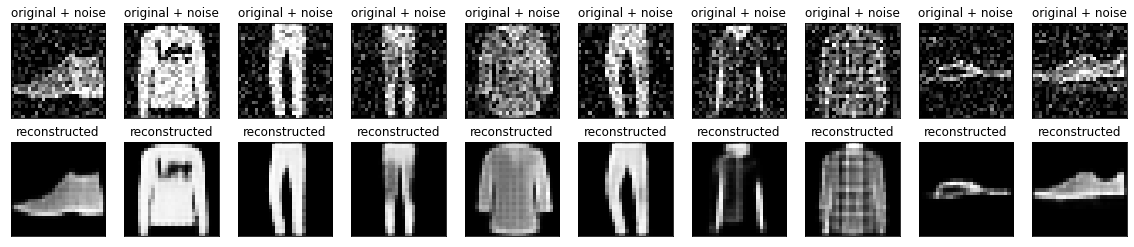

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [20]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [21]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG. 

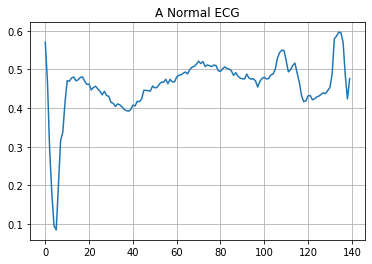

In [24]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

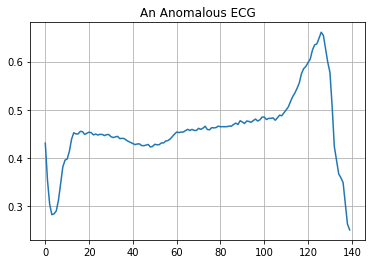

In [25]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [26]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [28]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20



1/5 [=====>........................] - ETA: 1s - loss: 0.0641


5/5 [==============================] - 0s 25ms/step - loss: 0.0611 - val_loss: 0.0545


Epoch 2/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0575


5/5 [==============================] - 0s 6ms/step - loss: 0.0568 - val_loss: 0.0523


Epoch 3/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0554


5/5 [==============================] - 0s 6ms/step - loss: 0.0547 - val_loss: 0.0508


Epoch 4/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0534


5/5 [==============================] - 0s 6ms/step - loss: 0.0524 - val_loss: 0.0490


Epoch 5/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0505


5/5 [==============================] - 0s 6ms/step - loss: 0.0495 - val_loss: 0.0472


Epoch 6/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0471


5/5 [==============================] - 0s 6ms/step - loss: 0.0460 - val_loss: 0.0461


Epoch 7/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0436


5/5 [==============================] - 0s 6ms/step - loss: 0.0428 - val_loss: 0.0451


Epoch 8/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0410


5/5 [==============================] - 0s 6ms/step - loss: 0.0397 - val_loss: 0.0432


Epoch 9/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0374


5/5 [==============================] - 0s 6ms/step - loss: 0.0364 - val_loss: 0.0414


Epoch 10/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0341


5/5 [==============================] - 0s 6ms/step - loss: 0.0337 - val_loss: 0.0403


Epoch 11/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0328


5/5 [==============================] - 0s 6ms/step - loss: 0.0315 - val_loss: 0.0394


Epoch 12/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0301


5/5 [==============================] - 0s 6ms/step - loss: 0.0297 - val_loss: 0.0385


Epoch 13/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0285


5/5 [==============================] - 0s 6ms/step - loss: 0.0282 - val_loss: 0.0378


Epoch 14/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0276


5/5 [==============================] - 0s 6ms/step - loss: 0.0270 - val_loss: 0.0372


Epoch 15/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0256


5/5 [==============================] - 0s 6ms/step - loss: 0.0261 - val_loss: 0.0366


Epoch 16/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0259


5/5 [==============================] - 0s 6ms/step - loss: 0.0252 - val_loss: 0.0361


Epoch 17/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0253


5/5 [==============================] - 0s 6ms/step - loss: 0.0245 - val_loss: 0.0355


Epoch 18/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0245


5/5 [==============================] - 0s 6ms/step - loss: 0.0238 - val_loss: 0.0350


Epoch 19/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0239


5/5 [==============================] - 0s 6ms/step - loss: 0.0232 - val_loss: 0.0347


Epoch 20/20

1/5 [=====>........................] - ETA: 0s - loss: 0.0234


5/5 [==============================] - 0s 6ms/step - loss: 0.0227 - val_loss: 0.0342


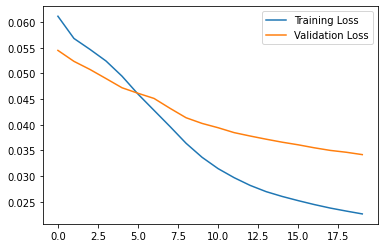

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

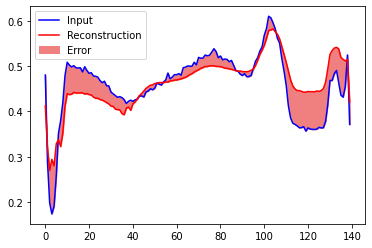

In [30]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

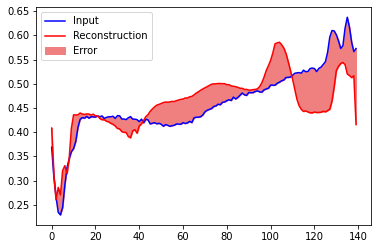

In [31]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

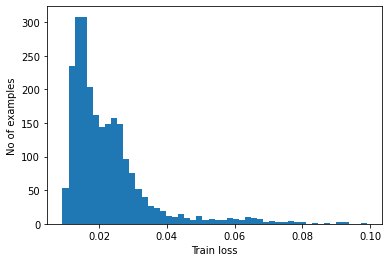

In [32]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [33]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.034232758


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial. 

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier. 

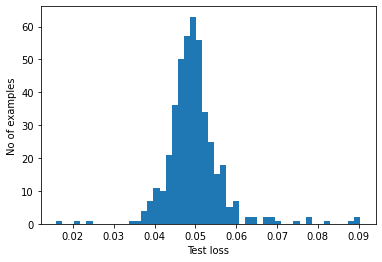

In [34]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [35]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429


## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
